<a href="https://colab.research.google.com/github/aldo-arevalo/mimic-code/blob/master/notebooks/ICUglycemia/Notebooks/2_0_ara_pairing_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Match GLC_BEFORE and GLC_AFTER for each insulin injection event


## Overview

This notebook contains the matching process for glucose readings and insulin injection events. We matched the glucose values before insulin injection(_glc_before_) and the glucose values after insulin injection(_glc_after_) for each insulin injection records. 
In addition, we also join the patient's age from table mimic_core.patients.
We imported the data in the MIMIC_IV database into the local PostgreSQL database, and we loaded the datafile __glucose_insulin_ICU.csv__ extracted in __1_data_extraction__ into new table __mimic_icu.glucose_insulin_ICU_1 .
To run this program, please change the database connection settings.


# Code

## Import dependencies and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from scipy import stats
from datetime import datetime
import time
import warnings
import psycopg2
# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML
# Change the following connection settings when you perform the queries
conn = psycopg2.connect(database="mimiciv", user="postgres", password="mypassword", host="127.0.0.1", port="5432")

def convert_to_datetime(df,time_cols):
    for t_col in time_cols:
        df[t_col] = pd.to_datetime(df[t_col],utc=True)
    return(df)

D:\anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\anaconda\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


### Change the timer of injection records to endtimer to obtain more glc_before events

In [2]:
glucose_insulin_ICU = pd.read_csv('./Data/glucose_insulin_ICU.csv')

In [3]:
glucose_insulin_ICU['timer'].loc[(glucose_insulin_ICU['glctimer'].isnull())]=glucose_insulin_ICU.loc[
                (glucose_insulin_ICU['glctimer'].isnull()),'endtime']

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
glucose_insulin_ICU.head(10)

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,inputamount,input_itemid,patientweight,event,glc,item_glc,glcsource,chart_store
0,10002013,23581541,39060235,2160-05-18 10:00:53+00:00,2160-05-19 17:33:33+00:00,1.314352,2160-05-18 10:26:00+00:00,NaN,2160-05-18 10:26:00+00:00,NaN,NaN,NaN,NaN,NaN,216.0,50809.0,BLOOD,0.0
1,10002013,23581541,39060235,2160-05-18 10:00:53+00:00,2160-05-19 17:33:33+00:00,1.314352,2160-05-18 11:23:00+00:00,NaN,2160-05-18 11:23:00+00:00,NaN,NaN,NaN,NaN,NaN,177.0,50809.0,BLOOD,0.0
2,10002013,23581541,39060235,2160-05-18 10:00:53+00:00,2160-05-19 17:33:33+00:00,1.314352,2160-05-18 12:20:00+00:00,NaN,2160-05-18 12:20:00+00:00,NaN,NaN,NaN,NaN,NaN,177.0,50809.0,BLOOD,0.0
3,10002013,23581541,39060235,2160-05-18 10:00:53+00:00,2160-05-19 17:33:33+00:00,1.314352,2160-05-18 13:02:00+00:00,NaN,2160-05-18 13:02:00+00:00,NaN,NaN,NaN,NaN,NaN,135.0,50809.0,BLOOD,0.0
4,10002013,23581541,39060235,2160-05-18 10:00:53+00:00,2160-05-19 17:33:33+00:00,1.314352,2160-05-18 14:46:00+00:00,NaN,2160-05-18 14:46:00+00:00,NaN,NaN,NaN,NaN,NaN,154.0,50809.0,BLOOD,0.0
5,10002013,23581541,39060235,2160-05-18 10:00:53+00:00,2160-05-19 17:33:33+00:00,1.314352,2160-05-18 15:01:00+00:00,2160-05-18 15:00:00+00:00,NaN,2160-05-18 15:01:00+00:00,2.0,223258.0,96.0,BOLUS_PUSH,NaN,NaN,NaN,NaN
6,10002013,23581541,39060235,2160-05-18 10:00:53+00:00,2160-05-19 17:33:33+00:00,1.314352,2160-05-18 16:03:00+00:00,NaN,2160-05-18 16:03:00+00:00,NaN,NaN,NaN,NaN,NaN,155.0,50809.0,BLOOD,0.0
7,10002013,23581541,39060235,2160-05-18 10:00:53+00:00,2160-05-19 17:33:33+00:00,1.314352,2160-05-18 16:16:00+00:00,2160-05-18 16:15:00+00:00,NaN,2160-05-18 16:16:00+00:00,2.0,223258.0,96.0,BOLUS_PUSH,NaN,NaN,NaN,NaN
8,10002013,23581541,39060235,2160-05-18 10:00:53+00:00,2160-05-19 17:33:33+00:00,1.314352,2160-05-18 17:00:00+00:00,NaN,2160-05-18 17:00:00+00:00,NaN,NaN,NaN,NaN,NaN,154.0,225664.0,fingerstick,0.0
9,10002013,23581541,39060235,2160-05-18 10:00:53+00:00,2160-05-19 17:33:33+00:00,1.314352,2160-05-18 17:01:00+00:00,2160-05-18 17:00:00+00:00,NaN,2160-05-18 17:01:00+00:00,2.0,223258.0,96.0,BOLUS_PUSH,NaN,NaN,NaN,NaN


In [5]:
glucose_insulin_ICU.sort_values(by = ['subject_id', 'hadm_id', 'stay_id','timer'])
glucose_insulin_ICU.to_csv("./Data/glucose_insulin_ICU.csv", 
                index=False, encoding='utf8')

#### ！load glucose_insulin_ICU.csv into new table mimic_icu.glucose_insulin_ICU_1 Before performing subsequent steps

In [6]:
#
sql  ="""
WITH pg AS(
    SELECT p1.*

    -- Column GLC_AL that would gather paired glucose values according to the proposed rules
    ,(CASE
       
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK','blood', 'fingerstick')
        -- Return the time between PRECEDING glucose measurement and insulin input 
        THEN (ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60))
        ELSE null END
    ) AS timediff_before,
    (CASE
       
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify posting glucose reading
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK','blood', 'fingerstick')
        -- Return the time between POSTING glucose measurement and insulin input 
        THEN (ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60))
        ELSE null END
    ) AS timediff_after

    FROM mimic_icu.glucose_insulin_ICU_1 AS p1
    WINDOW w AS(PARTITION BY CAST(p1.STAY_ID AS INT) ORDER BY p1.TIMER)
)
-- Create a colum that identifies the glucose readings were paired and are duplicated in pg
SELECT pg.*,mimic_core.patients.anchor_age
FROM pg left join mimic_core.patients on pg.subject_id=mimic_core.patients.subject_id
WINDOW x AS(PARTITION BY STAY_ID ORDER BY pg.timer)  order by SUBJECT_ID, HADM_ID, STAY_ID,timer

"""


In [7]:

ICUinputs_adjusted = pd.read_sql(sql, conn)
ICUinputs_adjusted.head(10)

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,...,input_itemid,patientweight,event,glc,item_glc,glcsource,chart_store,timediff_before,timediff_after,anchor_age
0,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 10:26:00,NaT,2160-05-18 10:26:00,NaT,...,NaN,NaN,None,216.0,50809.0,BLOOD,0.0,NaN,NaN,53
1,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 11:23:00,NaT,2160-05-18 11:23:00,NaT,...,NaN,NaN,None,177.0,50809.0,BLOOD,0.0,NaN,NaN,53
2,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 12:20:00,NaT,2160-05-18 12:20:00,NaT,...,NaN,NaN,None,177.0,50809.0,BLOOD,0.0,NaN,NaN,53
3,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 13:02:00,NaT,2160-05-18 13:02:00,NaT,...,NaN,NaN,None,135.0,50809.0,BLOOD,0.0,NaN,NaN,53
4,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 14:46:00,NaT,2160-05-18 14:46:00,NaT,...,NaN,NaN,None,154.0,50809.0,BLOOD,0.0,NaN,NaN,53
5,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 15:01:00,2160-05-18 15:00:00,NaT,2160-05-18 15:01:00,...,223258.0,96.0,BOLUS_PUSH,NaN,NaN,None,NaN,15.0,62.0,53
6,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 16:03:00,NaT,2160-05-18 16:03:00,NaT,...,NaN,NaN,None,155.0,50809.0,BLOOD,0.0,NaN,NaN,53
7,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 16:16:00,2160-05-18 16:15:00,NaT,2160-05-18 16:16:00,...,223258.0,96.0,BOLUS_PUSH,NaN,NaN,None,NaN,13.0,44.0,53
8,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 17:00:00,NaT,2160-05-18 17:00:00,NaT,...,NaN,NaN,None,154.0,225664.0,fingerstick,0.0,NaN,NaN,53
9,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 17:01:00,2160-05-18 17:00:00,NaT,2160-05-18 17:01:00,...,223258.0,96.0,BOLUS_PUSH,NaN,NaN,None,NaN,1.0,41.0,53


In [8]:
ICUinputs_adjusted.timediff_before.describe()

count    226644.000000
mean         42.990911
std          63.873263
min           0.000000
25%           9.000000
50%          26.000000
75%          53.000000
max        2044.000000
Name: timediff_before, dtype: float64

In [9]:
ICUinputs_adjusted.timediff_after.describe()

count    214601.000000
mean        223.711078
std         132.439198
min           0.000000
25%         109.000000
50%         239.000000
75%         321.000000
max        4299.000000
Name: timediff_after, dtype: float64

<ipython-input-24-24572899265a>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "c" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('D:/Desktop/论文/figures/timediff_brfore.png', c = 'c')


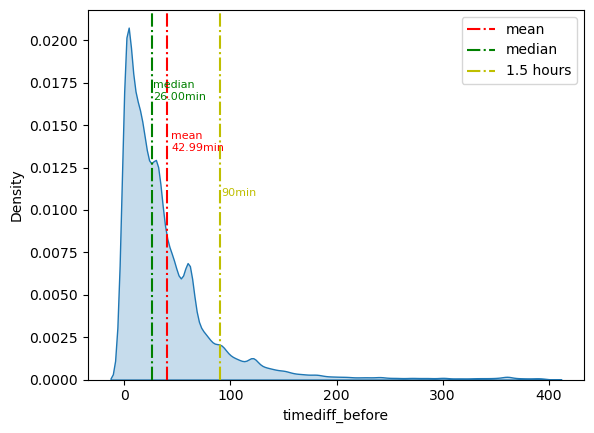

In [24]:
# Probability density curve for time diff before
s = ICUinputs_adjusted[(ICUinputs_adjusted["timediff_before"]<400)&(ICUinputs_adjusted["timediff_before"]>=0)]["timediff_before"]
sns.kdeplot(s, shade=True)
plt.axvline(s.mean(), label='mean',linestyle='-.', color='r')
plt.axvline(s.median(), label='median',linestyle='-.', color='g')
plt.axvline(90, label='1.5 hours',linestyle='-.', color='y')

plt.text(44,0.014,'mean\n42.99min', color='r',fontsize=8,verticalalignment='center')
plt.text(27,0.017,'median\n26.00min', color='g',fontsize=8,verticalalignment='center')
plt.text(91,0.011,'90min', color='y',fontsize=8,verticalalignment='center')


plt.legend()
plt.savefig('./figures/timediff_before.png', c = 'c')
plt.show()



In [25]:
ICUinputs_adjusted[ICUinputs_adjusted["timediff_before"]<=90].shape[0]/ICUinputs_adjusted[ICUinputs_adjusted["timediff_before"]>=0].shape[0]

0.8936437761423202

<ipython-input-36-66e354a3e654>:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "c" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('D:/Desktop/论文/figures/timediff_after.png', c = 'c')


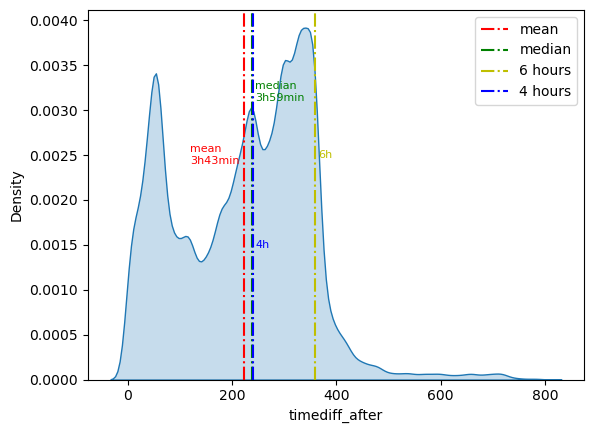

In [36]:
# Probability density curve for time diff after 
s = ICUinputs_adjusted[ICUinputs_adjusted["timediff_after"]<800]["timediff_after"]
sns.kdeplot(s, shade=True)
plt.axvline(s.mean(), label='mean',linestyle='-.', color='r')
plt.axvline(s.median(), label='median',linestyle='-.', color='g')
plt.axvline(360, label='6 hours',linestyle='-.', color='y')
plt.axvline(240, label='4 hours',linestyle='-.', color='b')

plt.text(120,0.0025,'mean\n3h43min', color='r',fontsize=8,verticalalignment='center')
plt.text(245,0.0032,'median\n3h59min', color='g',fontsize=8,verticalalignment='center')
plt.text(365,0.0025,'6h', color='y',fontsize=8,verticalalignment='center')
plt.text(245,0.0015,'4h', color='b',fontsize=8,verticalalignment='center')

plt.legend()
plt.savefig('./figures/timediff_after.png', c = 'c')
plt.show()



In [103]:
ICUinputs_adjusted[ICUinputs_adjusted["timediff_after"]<=360].shape[0]/ICUinputs_adjusted[ICUinputs_adjusted["timediff_after"]>=0].shape[0]

0.9229220739884716

In [104]:
ICUinputs_adjusted[ICUinputs_adjusted["timediff_after"]<=240].shape[0]/ICUinputs_adjusted[ICUinputs_adjusted["timediff_after"]>=0].shape[0]

0.5149044039869339

### Get Glc_before

In [105]:
sql  ="""
WITH pg AS(
    SELECT  p1.*

    -- Column GLC_AL that would gather paired glucose values according to the proposed rules
    ,(CASE
       
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
        -- Return the time between PRECEDING glucose measurement and insulin input 
        THEN (ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60))
        ELSE null END
    ) AS timediff_before
    ,(CASE
       
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify posting glucose reading
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
        -- Return the time between POSTING glucose measurement and insulin input 
        THEN (ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60))
        ELSE null END
    ) AS timediff_after
    
    ,(CASE
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 1ST CLAUSE
        -- When previous is glucose readings in 90 min,and the posterior glucose reading in 5 min
        -- When the  posterior-time-diff is less than the previus-time-diff
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
             -- Time-gap between  posterior glucose and insulin, should be larger than 10 minutes
            AND(ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)<=5)
            -- Time-gap between Preceding glucose and insulin <=90
            AND (ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90)
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                    ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 
                    ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)
                    )
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- When previous is glucose readings in 90 min,and  not statisfied the 1 Clause
        -- retrun previous min
        
        -- Identify an insulin event
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w))
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3ND CLAUSE
        -- When previous is glucose readings is larger than 90 min , and the posterior glucose reading in 10 min
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Time-gap between Preceding glucose and insulin <=90
            AND (ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 90)
             -- Time-gap between  posterior glucose and insulin, should be larger than 10 minutes
            AND(ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)<=10)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        -- When previous 2 is glucose readings in 90 min,and the posterior glucose reading in 5 min and shorter
        -- When the  posterior-time-diff is less than the previus-time-diff
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INJECTION','BOLUS_PUSH')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            AND ( -- postierior glucose time is shorter than 5 
               ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)<=5
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                    ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 
                    ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)
                    )
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        -- When previous 2 is glucose readings in 90 min,and the posterior glucose reading not satisfy the CLOUSE4
        -- retrun previous min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'fingerstick')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INJECTION','BOLUS_PUSH')
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.GLC,2) OVER(w))
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        -- When previous 2 is glucose readings not in 90 min,and the posterior glucose reading within 10 min
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'fingerstick')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INJECTION','BOLUS_PUSH')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Posterior glucose occurs within 10 minutes
            AND ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 10
            -- Preceding glucose 2 rows above occured  before 90
            AND ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 90
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLC_BEFORE
    ,(CASE
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 1ST CLAUSE
        -- When previous is glucose readings in 90 min,and the posterior glucose reading in 5 min
        -- When the  posterior-time-diff is less than the previus-time-diff
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
             -- Time-gap between  posterior glucose and insulin, should be larger than 10 minutes
            AND(ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)<=5)
            -- Time-gap between Preceding glucose and insulin <=90
            AND (ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90)
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                    ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 
                    ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)
                    )
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 1
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- When previous is glucose readings in 90 min,and  not statisfied the 1 Clause
        -- retrun previous min
        
        -- Identify an insulin event
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN 2
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3ND CLAUSE
        -- When previous is glucose readings is larger than 90 min , and the posterior glucose reading in 10 min
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Time-gap between Preceding glucose and insulin <=90
            AND (ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 90)
             -- Time-gap between  posterior glucose and insulin, should be larger than 10 minutes
            AND(ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)<=10)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 3
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        -- When previous 2 is glucose readings in 90 min,and the posterior glucose reading in 5 min and shorter
        -- When the  posterior-time-diff is less than the previus-time-diff
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INJECTION','BOLUS_PUSH')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            AND ( -- postierior glucose time is shorter than 5 
               ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)<=5
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                    ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 
                    ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)
                    )
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 4
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        -- When previous 2 is glucose readings in 90 min,and the posterior glucose reading not satisfy the CLOUSE4
        -- retrun previous min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'fingerstick')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INJECTION','BOLUS_PUSH')
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90
        -- Return the preceding glucose value 2 rows above
        THEN 5
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        -- When previous 2 is glucose readings not in 90 min,and the posterior glucose reading within 10 min
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'fingerstick')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INJECTION','BOLUS_PUSH')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Posterior glucose occurs within 10 minutes
            AND ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 10
            -- Preceding glucose 2 rows above occured  before 90
            AND ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 90
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 6
        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS CLAUSE_BEFORE
        ,(CASE
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 1ST CLAUSE
        -- When previous is glucose readings in 90 min,and the posterior glucose reading in 5 min
        -- When the  posterior-time-diff is less than the previus-time-diff
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
             -- Time-gap between  posterior glucose and insulin, should be larger than 10 minutes
            AND(ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)<=5)
            -- Time-gap between Preceding glucose and insulin <=90
            AND (ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90)
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                    ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 
                    ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)
                    )
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- When previous is glucose readings in 90 min,and  not statisfied the 1 Clause
        -- retrun previous min
        
        -- Identify an insulin event
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w))
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3ND CLAUSE
        -- When previous is glucose readings is larger than 90 min , and the posterior glucose reading in 10 min
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Time-gap between Preceding glucose and insulin <=90
            AND (ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 90)
             -- Time-gap between  posterior glucose and insulin, should be larger than 10 minutes
            AND(ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)<=10)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        -- When previous 2 is glucose readings in 90 min,and the posterior glucose reading in 5 min and shorter
        -- When the  posterior-time-diff is less than the previus-time-diff
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INJECTION','BOLUS_PUSH')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            AND ( -- postierior glucose time is shorter than 5 
               ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)<=5
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                    ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 
                    ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60)
                    )
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        -- When previous 2 is glucose readings in 90 min,and the posterior glucose reading not satisfy the CLOUSE4
        -- retrun previous min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'fingerstick')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INJECTION','BOLUS_PUSH')
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 90
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.TIMER,2) OVER(w))
        
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        -- When previous 2 is glucose readings not in 90 min,and the posterior glucose reading within 10 min
        -- return posterior min
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INJECTION', 'BOLUS_PUSH')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'fingerstick')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INJECTION','BOLUS_PUSH')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'fingerstick')
            -- Posterior glucose occurs within 10 minutes
            AND ABS((EXTRACT(EPOCH FROM (LEAD(p1.TIMER,1) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) <= 10
            -- Preceding glucose 2 rows above occured  before 90
            AND ABS((EXTRACT(EPOCH FROM (LAG(p1.TIMER,2) OVER(w))) - EXTRACT(EPOCH FROM  p1.TIMER))/60) > 90
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS TIMER_BEFORE
    
    
    FROM mimic_icu.glucose_insulin_ICU_1 AS p1
    WINDOW w AS(PARTITION BY CAST(p1.STAY_ID AS INT) ORDER BY p1.TIMER)
)
-- Create a colum that identifies the glucose readings were paired and are duplicated in pg
SELECT pg.*,mimic_core.patients.anchor_age
FROM pg left join mimic_core.patients on pg.subject_id=mimic_core.patients.subject_id
WINDOW x AS(PARTITION BY STAY_ID ORDER BY pg.timer)  order by SUBJECT_ID, HADM_ID, STAY_ID,timer

"""
WITH_GLC_BEFORE = pd.read_sql(sql, conn)

In [106]:
Insulin_WITH_GLC_BEFORE = WITH_GLC_BEFORE[WITH_GLC_BEFORE["inputamount"]>=0]

In [107]:
Insulin_WITH_GLC_BEFORE.head()

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,...,glc,item_glc,glcsource,chart_store,timediff_before,timediff_after,glc_before,clause_before,timer_before,anchor_age
5,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 15:01:00,2160-05-18 15:00:00,NaT,2160-05-18 15:01:00,...,NaN,NaN,None,NaN,15.0,62.0,154.0,2.0,2160-05-18 14:46:00,53
7,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 16:16:00,2160-05-18 16:15:00,NaT,2160-05-18 16:16:00,...,NaN,NaN,None,NaN,13.0,44.0,155.0,2.0,2160-05-18 16:03:00,53
9,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 17:01:00,2160-05-18 17:00:00,NaT,2160-05-18 17:01:00,...,NaN,NaN,None,NaN,1.0,41.0,154.0,2.0,2160-05-18 17:00:00,53
12,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 18:51:00,2160-05-18 18:50:00,NaT,2160-05-18 18:51:00,...,NaN,NaN,None,NaN,0.0,161.0,179.0,2.0,2160-05-18 18:51:00,53
22,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-19 06:45:00,2160-05-19 06:44:00,NaT,2160-05-19 06:45:00,...,NaN,NaN,None,NaN,21.0,105.0,106.0,2.0,2160-05-19 06:24:00,53


In [108]:
Insulin_WITH_GLC_BEFORE.tail()

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,...,glc,item_glc,glcsource,chart_store,timediff_before,timediff_after,glc_before,clause_before,timer_before,anchor_age
1317309,19999840,21033226,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-16 10:12:00,2164-09-16 10:11:00,NaT,2164-09-16 10:12:00,...,NaN,NaN,None,NaN,12.0,348.0,193.0,2.0,2164-09-16 10:00:00,58
1317311,19999840,21033226,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-16 16:54:00,2164-09-16 16:53:00,NaT,2164-09-16 16:54:00,...,NaN,NaN,None,NaN,54.0,300.0,163.0,2.0,2164-09-16 16:00:00,58
1317313,19999840,21033226,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-16 22:10:00,2164-09-16 22:09:00,NaT,2164-09-16 22:10:00,...,NaN,NaN,None,NaN,16.0,279.0,175.0,2.0,2164-09-16 21:54:00,58
1317315,19999840,21033226,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-17 04:32:00,2164-09-17 04:31:00,NaT,2164-09-17 04:32:00,...,NaN,NaN,None,NaN,103.0,203.0,NaN,NaN,NaT,58
1317319,19999840,21033226,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-17 09:31:00,2164-09-17 09:30:00,NaT,2164-09-17 09:31:00,...,NaN,NaN,None,NaN,31.0,222.0,179.0,2.0,2164-09-17 09:00:00,58


In [109]:
#统计
print("Total insulin injection event: {}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['inputamount']>=0].shape[0]))
print("Of which:")
print("Use rule 1 to match the before blood glucose value：{}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['clause_before']==1].shape[0]))
print("Use rule 2 to match the before blood glucose value：{}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['clause_before']==2].shape[0]))
print("Use rule 3 to match the before blood glucose value：{}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['clause_before']==3].shape[0]))
print("Use rule 4 to match the before blood glucose value：{}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['clause_before']==4].shape[0]))
print("Use rule 5 to match the before blood glucose value：{}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['clause_before']==5].shape[0]))
print("Use rule 6 to match the before blood glucose value：{}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['clause_before']==6].shape[0]))
print("The total of matched to the before blood glucose value：{}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['clause_before']>=0].shape[0]))
print("The total of unmatched to the before blood glucose value：{}".format(Insulin_WITH_GLC_BEFORE[np.isnan(Insulin_WITH_GLC_BEFORE['clause_before'])].shape[0]))

Total insulin injection event: 234314
Of which:
Use rule 1 to match the before blood glucose value：1432
Use rule 2 to match the before blood glucose value：201107
Use rule 3 to match the before blood glucose value：1320
Use rule 4 to match the before blood glucose value：90
Use rule 5 to match the before blood glucose value：961
Use rule 6 to match the before blood glucose value：1003
The total of matched to the before blood glucose value：205913
The total of unmatched to the before blood glucose value：28401


In [110]:
# Calculate the time interval for insulin input events
df_both_raw = Insulin_WITH_GLC_BEFORE.copy(deep=True)
df_both_raw['diff'] = df_both_raw.sort_values(['stay_id',
                                               'timer']).groupby('stay_id')['timer'].diff().copy()
df_both_raw['diff_hr']= df_both_raw['diff'].dt.seconds/3600

display(HTML('<h4>Time lapse between Insulin Inputs</h4>'))
print("Time lapse (hr) betweenInsulin Inputs/ICU stay: {:0.2f} +/- {:0.2f}".format(
    df_both_raw['diff_hr'].mean(),df_both_raw['diff_hr'].std()))

Time lapse (hr) betweenInsulin Inputs/ICU stay: 7.50 +/- 4.94


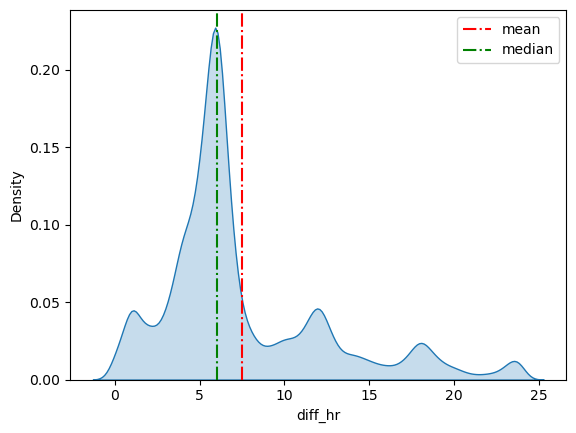

In [111]:
s =  df_both_raw['diff_hr']
sns.kdeplot(s, shade=True)   
plt.axvline(s.mean(), label='mean',linestyle='-.', color='r')
plt.axvline(s.median(), label='median',linestyle='-.', color='g')

plt.legend()
plt.show()


In [112]:
df_both_raw['diff_hr'].describe()

count    202400.000000
mean          7.502756
std           4.944028
min           0.000000
25%           4.700000
50%           6.000000
75%           9.516667
max          23.983333
Name: diff_hr, dtype: float64

In [114]:
# Match after blood glucose, 
# and select the blood glucose detection event whose timediff is less than 6 hours and closest to 4 hours after injection
import time
start = time.time()
WITH_GLC_BEFORE['glc_after'] = np.NaN
WITH_GLC_BEFORE['timer_after'] = pd.NaT
STAY_ID = 0
for i in range(0, len(WITH_GLC_BEFORE)):
    x = WITH_GLC_BEFORE.iloc[i]
    if np.isnan(x['inputamount']):
        continue
    if x['stay_id']!=STAY_ID:
        STAY_ID = x['stay_id']
    j = i + 1
    timediff_min = 9999
    glcafter = np.NaN
    timer_after = pd.NaT
    while(j<len(WITH_GLC_BEFORE) and np.isnan(WITH_GLC_BEFORE.iloc[j]['inputamount']) and WITH_GLC_BEFORE.iloc[j]['stay_id']==STAY_ID):
        t = abs((WITH_GLC_BEFORE.iloc[j]['timer']-x['timer']).total_seconds()/60 ) # timediff in minutes
        if  t > 360:
            break
        else:
            if abs(t-240) < timediff_min:
                timediff_min = abs(t-240)
                glcafter = WITH_GLC_BEFORE.iloc[j]['glc']
                timer_after = WITH_GLC_BEFORE.iloc[j]['timer']
                j = j+1;
            else:
                break;
    if i%100==0:
        print('row {} ，GLC：{}'.format(i,glcafter))
    WITH_GLC_BEFORE.loc[i,'glc_after'] = glcafter
    WITH_GLC_BEFORE.loc[i,'timer_after'] = timer_after

print("finish")
end = time.time()
print (end-start)

row 600 ，GLC：167.0
row 1700 ，GLC：125.0
row 2300 ，GLC：248.0
row 2500 ，GLC：nan
row 2700 ，GLC：204.0
row 3500 ，GLC：215.0
row 3700 ，GLC：127.0
row 4900 ，GLC：113.0
row 6200 ，GLC：289.0
row 6800 ，GLC：213.0
row 7000 ，GLC：209.0
row 7200 ，GLC：285.0
row 7900 ，GLC：140.0
row 8900 ，GLC：234.0
row 9000 ，GLC：200.0
row 9500 ，GLC：320.0
row 9600 ，GLC：174.0
row 10200 ，GLC：89.0
row 10500 ，GLC：178.0
row 11300 ，GLC：151.0
row 11800 ，GLC：81.0
row 11900 ，GLC：160.0
row 12700 ，GLC：179.0
row 12800 ，GLC：125.0
row 13700 ，GLC：nan
row 14300 ，GLC：143.0
row 15300 ，GLC：216.0
row 15400 ，GLC：108.0
row 15600 ，GLC：87.0
row 15800 ，GLC：117.0
row 16200 ，GLC：164.0
row 16300 ，GLC：177.0
row 16600 ，GLC：166.0
row 17200 ，GLC：174.0
row 17700 ，GLC：147.0
row 18300 ，GLC：127.0
row 18400 ，GLC：217.0
row 19300 ，GLC：231.0
row 20800 ，GLC：95.0
row 21100 ，GLC：189.0
row 23100 ，GLC：197.0
row 23800 ，GLC：nan
row 24300 ，GLC：160.0
row 24600 ，GLC：114.0
row 24900 ，GLC：108.0
row 25400 ，GLC：202.0
row 26200 ，GLC：nan
row 27100 ，GLC：97.0
row 28000 ，GLC：120.0
ro

row 216500 ，GLC：214.0
row 217000 ，GLC：131.0
row 217700 ，GLC：143.0
row 218400 ，GLC：185.0
row 219100 ，GLC：160.0
row 219700 ，GLC：153.0
row 220400 ，GLC：160.0
row 220500 ，GLC：nan
row 220700 ，GLC：289.0
row 222100 ，GLC：nan
row 222300 ，GLC：162.0
row 224700 ，GLC：125.0
row 224900 ，GLC：177.0
row 225200 ，GLC：143.0
row 226100 ，GLC：198.0
row 228400 ，GLC：195.0
row 230200 ，GLC：168.0
row 230300 ，GLC：227.0
row 230400 ，GLC：167.0
row 230500 ，GLC：108.0
row 231000 ，GLC：166.0
row 231100 ，GLC：103.0
row 232000 ，GLC：139.0
row 232600 ，GLC：130.0
row 232800 ，GLC：125.0
row 232900 ，GLC：nan
row 233000 ，GLC：228.0
row 233900 ，GLC：189.0
row 234100 ，GLC：132.0
row 234200 ，GLC：211.0
row 234700 ，GLC：195.0
row 235400 ，GLC：119.0
row 236400 ，GLC：127.0
row 237100 ，GLC：190.0
row 237300 ，GLC：142.0
row 238000 ，GLC：117.0
row 238200 ，GLC：157.0
row 240000 ，GLC：378.0
row 241200 ，GLC：164.0
row 241900 ，GLC：nan
row 242300 ，GLC：137.0
row 242400 ，GLC：185.0
row 242500 ，GLC：nan
row 242900 ，GLC：nan
row 243400 ，GLC：nan
row 243700 ，GLC：242.0
ro

row 449800 ，GLC：147.0
row 451000 ，GLC：112.0
row 451600 ，GLC：199.0
row 451700 ，GLC：181.0
row 452000 ，GLC：138.0
row 453500 ，GLC：116.0
row 453700 ，GLC：494.0
row 453800 ，GLC：188.0
row 454500 ，GLC：423.0
row 454600 ，GLC：185.0
row 454800 ，GLC：nan
row 455100 ，GLC：160.0
row 455800 ，GLC：125.0
row 456400 ，GLC：157.0
row 456600 ，GLC：nan
row 456900 ，GLC：138.0
row 457100 ，GLC：nan
row 458200 ，GLC：216.0
row 458300 ，GLC：269.0
row 459100 ，GLC：114.0
row 459300 ，GLC：105.0
row 459400 ，GLC：371.0
row 459900 ，GLC：153.0
row 460000 ，GLC：137.0
row 461000 ，GLC：106.0
row 462300 ，GLC：119.0
row 463000 ，GLC：234.0
row 463700 ，GLC：180.0
row 464100 ，GLC：165.0
row 464800 ，GLC：259.0
row 466700 ，GLC：190.0
row 467600 ，GLC：214.0
row 469100 ，GLC：152.0
row 469800 ，GLC：191.0
row 470600 ，GLC：135.0
row 471000 ，GLC：130.0
row 471400 ，GLC：183.0
row 471600 ，GLC：154.0
row 472100 ，GLC：149.0
row 472200 ，GLC：nan
row 472300 ，GLC：161.0
row 472400 ，GLC：181.0
row 473000 ，GLC：113.0
row 473700 ，GLC：135.0
row 474100 ，GLC：163.0
row 474300 ，GLC：na

row 676500 ，GLC：230.0
row 677100 ，GLC：184.0
row 677200 ，GLC：168.0
row 677300 ，GLC：245.0
row 677400 ，GLC：295.0
row 677500 ，GLC：165.0
row 677800 ，GLC：271.0
row 678500 ，GLC：200.0
row 679000 ，GLC：199.0
row 679400 ，GLC：140.0
row 680100 ，GLC：69.0
row 680900 ，GLC：nan
row 682800 ，GLC：173.0
row 682900 ，GLC：226.0
row 684500 ，GLC：169.0
row 685800 ，GLC：174.0
row 686500 ，GLC：167.0
row 687600 ，GLC：nan
row 689300 ，GLC：nan
row 690300 ，GLC：129.0
row 690400 ，GLC：nan
row 690700 ，GLC：226.0
row 691300 ，GLC：148.0
row 691900 ，GLC：214.0
row 692100 ，GLC：154.0
row 692300 ，GLC：nan
row 693500 ，GLC：243.0
row 693900 ，GLC：192.0
row 694000 ，GLC：164.0
row 694700 ，GLC：213.0
row 695300 ，GLC：145.0
row 695700 ，GLC：226.0
row 696000 ，GLC：247.0
row 696600 ，GLC：nan
row 696700 ，GLC：115.0
row 697200 ，GLC：122.0
row 697400 ，GLC：172.0
row 697600 ，GLC：207.0
row 698600 ，GLC：251.0
row 700100 ，GLC：nan
row 701400 ，GLC：nan
row 702100 ，GLC：nan
row 702600 ，GLC：93.0
row 702900 ，GLC：139.0
row 703600 ，GLC：nan
row 704000 ，GLC：nan
row 704100 ，

row 880200 ，GLC：115.0
row 880300 ，GLC：nan
row 882500 ，GLC：132.0
row 882800 ，GLC：118.0
row 883000 ，GLC：120.0
row 885300 ，GLC：136.0
row 885900 ，GLC：117.0
row 886700 ，GLC：190.0
row 888100 ，GLC：nan
row 888900 ，GLC：217.0
row 890000 ，GLC：nan
row 891100 ，GLC：nan
row 891700 ，GLC：168.0
row 891800 ，GLC：nan
row 892100 ，GLC：299.0
row 892400 ，GLC：209.0
row 892800 ，GLC：100.0
row 893700 ，GLC：205.0
row 894400 ，GLC：143.0
row 894700 ，GLC：263.0
row 894900 ，GLC：150.0
row 895200 ，GLC：139.0
row 895400 ，GLC：330.0
row 896700 ，GLC：143.0
row 896800 ，GLC：185.0
row 897100 ，GLC：nan
row 898300 ，GLC：124.0
row 898500 ，GLC：114.0
row 898800 ，GLC：120.0
row 899200 ，GLC：nan
row 899700 ，GLC：180.0
row 900100 ，GLC：209.0
row 900600 ，GLC：161.0
row 900900 ，GLC：144.0
row 901300 ，GLC：181.0
row 901800 ，GLC：nan
row 903000 ，GLC：185.0
row 903700 ，GLC：228.0
row 906600 ，GLC：284.0
row 907700 ，GLC：134.0
row 908000 ，GLC：154.0
row 908900 ，GLC：239.0
row 909300 ，GLC：129.0
row 910100 ，GLC：268.0
row 910300 ，GLC：166.0
row 911200 ，GLC：160.0
row 

row 1111700 ，GLC：139.0
row 1112200 ，GLC：218.0
row 1113500 ，GLC：179.0
row 1114000 ，GLC：231.0
row 1114700 ，GLC：134.0
row 1115000 ，GLC：145.0
row 1115500 ，GLC：186.0
row 1115600 ，GLC：162.0
row 1115700 ，GLC：111.0
row 1115800 ，GLC：104.0
row 1116900 ，GLC：296.0
row 1117200 ，GLC：157.0
row 1117900 ，GLC：121.0
row 1118100 ，GLC：121.0
row 1119200 ，GLC：141.0
row 1119900 ，GLC：181.0
row 1120500 ，GLC：nan
row 1121000 ，GLC：nan
row 1123400 ，GLC：289.0
row 1124000 ，GLC：195.0
row 1125000 ，GLC：167.0
row 1125100 ，GLC：398.0
row 1125800 ，GLC：nan
row 1126000 ，GLC：159.0
row 1126100 ，GLC：144.0
row 1126300 ，GLC：162.0
row 1126400 ，GLC：nan
row 1127500 ，GLC：128.0
row 1127900 ，GLC：119.0
row 1128000 ，GLC：261.0
row 1128200 ，GLC：198.0
row 1128300 ，GLC：161.0
row 1128400 ，GLC：271.0
row 1128600 ，GLC：166.0
row 1129000 ，GLC：333.0
row 1129100 ，GLC：131.0
row 1129400 ，GLC：339.0
row 1129800 ，GLC：298.0
row 1130700 ，GLC：175.0
row 1131400 ，GLC：172.0
row 1132700 ，GLC：198.0
row 1133200 ，GLC：124.0
row 1133400 ，GLC：162.0
row 1133900 ，GLC：20

In [116]:
print("finish")

finish


In [117]:
WITH_GLC_BEFORE.tail(50)

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,...,glcsource,chart_store,timediff_before,timediff_after,glc_before,clause_before,timer_before,anchor_age,glc_after,timer_after
1317274,19999828,25744818,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-09 11:57:00,NaT,2149-01-09 11:57:00,NaT,...,fingerstick,1.0,NaN,NaN,NaN,NaN,NaT,46,NaN,NaT
1317275,19999828,25744818,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-09 13:00:00,NaT,2149-01-09 13:00:00,NaT,...,fingerstick,0.0,NaN,NaN,NaN,NaN,NaT,46,NaN,NaT
1317276,19999828,25744818,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-09 13:53:00,NaT,2149-01-09 13:53:00,NaT,...,BLOOD,0.0,NaN,NaN,NaN,NaN,NaT,46,NaN,NaT
1317277,19999828,25744818,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-09 14:22:00,NaT,2149-01-09 14:22:00,NaT,...,fingerstick,0.0,NaN,NaN,NaN,NaN,NaT,46,NaN,NaT
1317278,19999828,25744818,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-09 15:00:00,NaT,2149-01-09 15:00:00,NaT,...,fingerstick,0.0,NaN,NaN,NaN,NaN,NaT,46,NaN,NaT
1317279,19999828,25744818,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-09 15:09:00,2149-01-09 15:08:00,NaT,2149-01-09 15:09:00,...,None,NaN,9.0,111.0,366.0,2.0,2149-01-09 15:00:00,46,184.0,2149-01-09 18:00:00
1317280,19999828,25744818,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-09 17:00:00,NaT,2149-01-09 17:00:00,NaT,...,fingerstick,0.0,NaN,NaN,NaN,NaN,NaT,46,NaN,NaT
1317281,19999828,25744818,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-09 18:00:00,NaT,2149-01-09 18:00:00,NaT,...,fingerstick,0.0,NaN,NaN,NaN,NaN,NaT,46,NaN,NaT
1317282,19999828,25744818,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-09 18:43:00,2149-01-09 18:42:00,NaT,2149-01-09 18:43:00,...,None,NaN,43.0,56.0,184.0,2.0,2149-01-09 18:00:00,46,182.0,2149-01-09 21:57:00
1317283,19999828,25744818,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-09 19:39:00,NaT,2149-01-09 19:39:00,NaT,...,BLOOD,0.0,NaN,NaN,NaN,NaN,NaT,46,NaN,NaT


In [118]:
WITH_GLC_BEFORE.to_csv("./Data/Pair_With_Time.csv", index=False, encoding='utf8', header = True)

In [124]:
print("Total insulin injection event: {}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['inputamount']>=0].shape[0]))
print("Of which:")
print("mathced glc_before：{}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['glc_before']>=0].shape[0]))
print("mathced glc_after：{}".format(WITH_GLC_BEFORE[WITH_GLC_BEFORE['glc_after']>=0].shape[0]))
Insulin_WITH_GLC_BEFORE = WITH_GLC_BEFORE[WITH_GLC_BEFORE['inputamount']>=0]
print("failed to match glc_after：{}".format(Insulin_WITH_GLC_BEFORE[np.isnan(Insulin_WITH_GLC_BEFORE['glc_after'])].shape[0]))
no_after=Insulin_WITH_GLC_BEFORE[np.isnan(Insulin_WITH_GLC_BEFORE['glc_after'])]
x=Insulin_WITH_GLC_BEFORE[Insulin_WITH_GLC_BEFORE['glc_before']>=0]
y=Insulin_WITH_GLC_BEFORE[Insulin_WITH_GLC_BEFORE['glc_after']>=0]
print("matched matched before and after：{}".format(x[x['glc_after']>=0].shape[0]))
print("matched matched before and after：{}".format(y[y['glc_before']>=0].shape[0]))

pair_with_before_after = x[x['glc_after']>=0]

print("\nAmong Insulin injection events with glc_before and glc_after：")
print("Entries:             {}".format(pair_with_before_after.shape[0]))
print("Patients:            {}".format(pair_with_before_after['subject_id'].nunique()))
bol_long_patients2 = pair_with_before_after['subject_id'].unique()
print("Hospital admissions: {}".format(pair_with_before_after ['hadm_id'].nunique()))
print('ICU stays:           {}'.format(pair_with_before_after ['stay_id'].nunique()))


Total insulin injection event: 234314
Of which:
mathced glc_before：205913
mathced glc_after：198047
failed to match glc_after：36267
matched matched before and after：174280
matched matched before and after：174280

Among Insulin injection events with glc_before and glc_after：
Entries:             174280
Patients:            22618
Hospital admissions: 26707
ICU stays:           28608
